In [ ]:
!pip install tqdm timm transformers kaggle albumentations "opencv-python-headless<4.3"

In [ ]:
# https://www.kaggle.com/docs/api

# https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
!kaggle datasets download -d hsankesara/flickr-image-dataset
![ ! -d  ./flickr30k_images ] && unzip -q flickr-image-dataset.zip

## Prepare

In [1]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
import albumentations as A
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertTokenizer

/tmp/ipykernel_2054/896934503.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dataset_path = "flickr30k_images"
images_path = f"{dataset_path}/{dataset_path}" 
df = pd.read_csv(f"{dataset_path}/results.csv", delimiter="|")
df.columns = ['image', 'caption_number', 'caption']
df['caption'] = df['caption'].str.lstrip()
df['caption_number'] = df['caption_number'].str.lstrip()
df.loc[19999, 'caption_number'] = "4"
df.loc[19999, 'caption'] = "A dog runs across the grass ."
ids = [id_ for id_ in range(len(df) // 5) for _ in range(5)]
df['id'] = ids

## Model

In [3]:
class CLIPConfig:
    temperature = 1.0
    transform_size = 224
    projection_dim = 256 
    projection_dropout = 0.1
    image_embedding_dim = 2048
    text_embedding_dim = 768
    text_encoder_model_name = 'distilbert-base-uncased' 
    image_encoder_model_name = 'resnet50'
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    head_lr = 1e-3
    weight_decay = 1e-3
    lr_scheduler_patience = 1
    lr_scheduler_factor = 0.8
    training_epochs = 4
    data_loader_batch_size = 40
    data_loader_workers = 5
    token_max_length = 200
    image_path = images_path
    text_model_loader=DistilBertModel
    text_tokenizer_loader=DistilBertTokenizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
######################
# Utils
######################

tokenizer = CLIPConfig.text_tokenizer_loader.from_pretrained(CLIPConfig.text_encoder_model_name)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def get_transforms():
    return A.Compose(
        [
            A.Resize(CLIPConfig.transform_size, CLIPConfig.transform_size, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True)
        ]
    )

def create_dataframes():
    max_id = df["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = df[df["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = df[df["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

def cross_entropy(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    return (-targets * log_softmax(preds)).sum(1)

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

###################
# Datasets
##################
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CLIPConfig.token_max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CLIPConfig.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]
        return item

    def __len__(self):
        return len(self.captions)
    
def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=get_transforms(),
    )
    
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CLIPConfig.data_loader_batch_size,
        num_workers=CLIPConfig.data_loader_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader    

########################################
# Projection
#######################################
class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim, projection_dim, dropout):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x    
    
####################
# Encoders
####################
class ImageEncoder(nn.Module):
    def __init__(self, model_name, trainable):
        super().__init__()
        self.model = timm.create_model(model_name, True, num_classes=0, global_pool="avg")
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)
    
class TextEncoder(nn.Module):
    def __init__(self, model_name, trainable, model_loader):
        super().__init__()
        self.model = model_loader.from_pretrained(model_name)
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]  

###################################
# Model
##################################
class CLIPModel(nn.Module):
    def __init__(self, temperature, image_embedding, text_embedding, trainable, image_encoder_model_name, text_encoder_model_name, projection_dim, projection_dropout, text_model_loader):
        super().__init__()
        self.image_encoder = ImageEncoder(model_name=image_encoder_model_name, trainable=trainable)
        self.text_encoder = TextEncoder(model_name=text_encoder_model_name, trainable=trainable, model_loader=text_model_loader)
        self.image_projection = ProjectionHead(embedding_dim=image_embedding, projection_dim=projection_dim, dropout=projection_dropout)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding, projection_dim=projection_dim, dropout=projection_dropout)
        self.temperature = temperature

    def forward(self, batch):
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets)
        images_loss = cross_entropy(logits.T, targets.T)
        loss =  (images_loss + texts_loss) / 2.0
        return loss.mean()    

## Load Data

In [5]:
train_df, valid_df = create_dataframes()
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

## Training

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CLIPConfig.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CLIPConfig.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

def train_loop(train_loader, valid_loader, model, optimizer, scheduler):
    best_loss = float('inf')
    print('Running....')
    for epoch in range(CLIPConfig.training_epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, scheduler)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            print('Saving best model...')
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
        
        scheduler.step(valid_loss.avg)

In [ ]:
model = CLIPModel(
    temperature=CLIPConfig.temperature, 
    image_embedding=CLIPConfig.image_embedding_dim, 
    text_embedding=CLIPConfig.text_embedding_dim, 
    trainable=True, 
    image_encoder_model_name=CLIPConfig.image_encoder_model_name, 
    text_encoder_model_name=CLIPConfig.text_encoder_model_name, 
    projection_dim=CLIPConfig.projection_dim, 
    projection_dropout=CLIPConfig.projection_dropout,
    text_model_loader=CLIPConfig.text_model_loader,
).to(CLIPConfig.device)

In [ ]:
optimizer = torch.optim.AdamW([
    {"params": model.image_encoder.parameters(), "lr": CLIPConfig.image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": CLIPConfig.text_encoder_lr},
    {"params": itertools.chain(model.image_projection.parameters(), model.text_projection.parameters()), "lr": CLIPConfig.head_lr, "weight_decay": CLIPConfig.weight_decay}
], weight_decay=0.)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CLIPConfig.lr_scheduler_patience, factor=CLIPConfig.lr_scheduler_factor
)

In [ ]:
train_loop(train_loader, valid_loader, model, optimizer, scheduler)

## Inference

In [7]:
def load_inference_model():
    inf_model = CLIPModel(
        temperature=CLIPConfig.temperature, 
        image_embedding=CLIPConfig.image_embedding_dim, 
        text_embedding=CLIPConfig.text_embedding_dim, 
        trainable=False, 
        image_encoder_model_name=CLIPConfig.image_encoder_model_name, 
        text_encoder_model_name=CLIPConfig.text_encoder_model_name, 
        projection_dim=CLIPConfig.projection_dim, 
        projection_dropout=CLIPConfig.projection_dropout,
        text_model_loader=CLIPConfig.text_model_loader,
    ).to(CLIPConfig.device)

    inf_model.load_state_dict(torch.load('./best.pt', map_location=CLIPConfig.device))
    inf_model.eval()
    return inf_model

def get_image_embeddings(inf_model, data_loader):
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            image_features = inf_model.image_encoder(batch["image"].to(CLIPConfig.device))
            embeds = inf_model.image_projection(image_features)
            valid_image_embeddings.append(embeds)
    return torch.cat(valid_image_embeddings)

def find_match_indexes(inf_model, image_embeddings, query, n, image_filenames):
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CLIPConfig.device) for key, values in encoded_query.items()
    }
    
    with torch.no_grad():
        text_features = inf_model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = inf_model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    return matches

def show_matches(indexes):
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(indexes, axes.flatten()):
        image_path = f"{CLIPConfig.image_path}/{match}"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    plt.show()

In [8]:
inf_model = load_inference_model()
embeddings = get_image_embeddings(inf_model, valid_loader)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/795 [00:00<?, ?it/s]

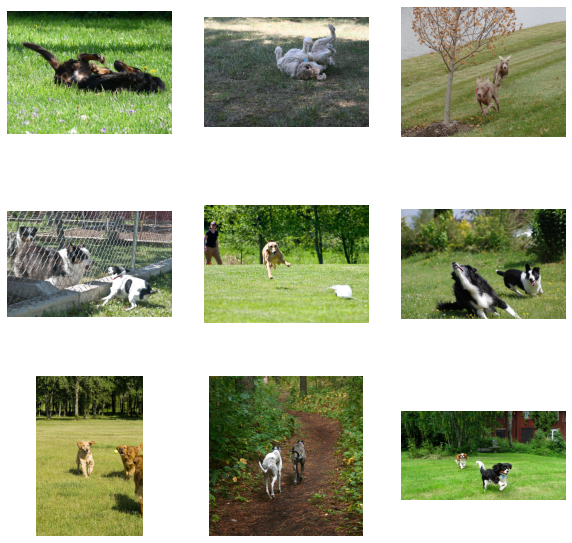

In [15]:
match_indexes = find_match_indexes(inf_model, embeddings, 'dogs playing in the grass', 9, valid_loader.dataset.image_filenames)
show_matches(match_indexes)

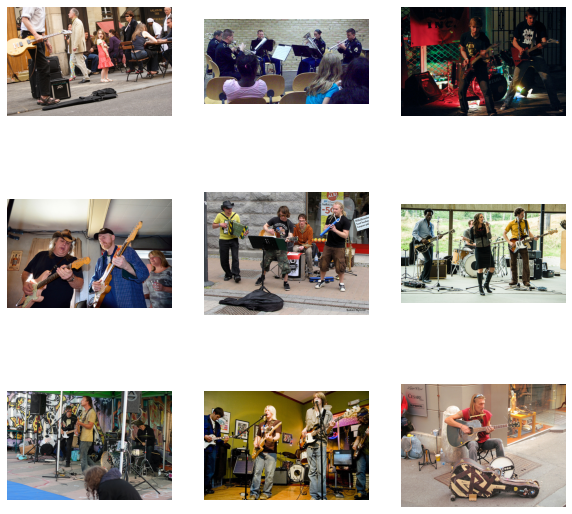

In [17]:
match_indexes = find_match_indexes(inf_model, embeddings, 'people playing guitar', 9, valid_loader.dataset.image_filenames)
show_matches(match_indexes)

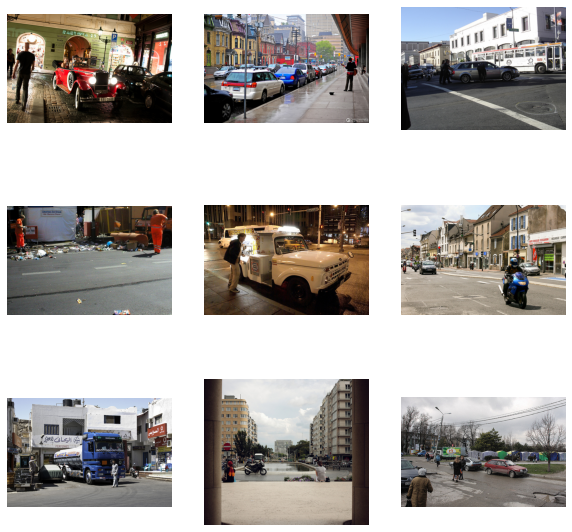

In [20]:
match_indexes = find_match_indexes(inf_model, embeddings, 'vehicles on the streets', 9, valid_loader.dataset.image_filenames)
show_matches(match_indexes)